# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

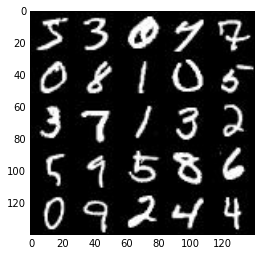

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

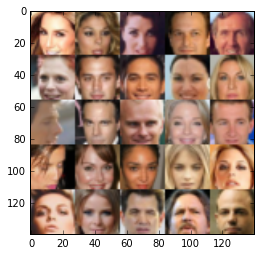

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # but I hear,  nchw have best performance!
#     image = tf.placeholder(tf.float32, shape=[None, image_channels, 
#                                               image_height, image_width])
    image = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, shape=[None, z_dim])
    lr = tf.placeholder(tf.float32)

    return image, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse) as scope:
        initer = tf.truncated_normal_initializer(stddev=0.02)
        net = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                               kernel_initializer=initer)
        relu1 = tf.maximum(alpha * net, net)
        # 14x14x64
        
        net = tf.layers.conv2d(net, 128, 5, strides=2, padding='same',
                              kernel_initializer=initer)
        net = tf.layers.batch_normalization(net, training=True)
        net = tf.maximum(alpha * net, net)
        # 7x7x128
        
        net = tf.layers.conv2d(net, 256, 5, strides=2, padding='same',
                              kernel_initializer=initer)
        net = tf.layers.batch_normalization(net, training=True)
        net = tf.maximum(alpha * net, net)
        # 4x4x256

        net = tf.layers.conv2d(net, 512, 5, strides=2, padding='same',
                              kernel_initializer=initer)
        net = tf.layers.batch_normalization(net, training=True)
        net = tf.maximum(alpha * net, net)
        # 2x2x512
        
        # Flatten it
        shape = net.get_shape().as_list()
        net = tf.reshape(net, (-1, shape[1] * shape[2] * shape[3]))
        logits = tf.layers.dense(net, 1, kernel_initializer=initer)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train) as scope:
        initer = tf.truncated_normal_initializer(stddev=0.02)
        # First fully connected layer
        net = tf.layers.dense(z, 2 * 2 * 512)
        # Reshape it to start the convolutional stack
        net = tf.reshape(net, (-1, 2, 2, 512))
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha * net, net)
        # 2x2x512 now
        
        net = tf.layers.conv2d_transpose(net, 256, 5, strides=2, padding='same',
                                        kernel_initializer=initer)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha * net, net)
        # 4x4x256 now
        
        net = tf.layers.conv2d_transpose(net, 128, 4, strides=1, padding='valid',
                                        kernel_initializer=initer)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha * net, net)
        # 7x7x128 now
        
        net = tf.layers.conv2d_transpose(net, 64, 5, strides=2, padding='same',
                                        kernel_initializer=initer)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha * net, net)
        # 14x14x64 now
        
        # Output layer
        net = tf.layers.conv2d_transpose(net, out_channel_dim, 5, strides=2, 
                                            padding='same', kernel_initializer=initer)
        # 28x28x3 now

        out = tf.tanh(net)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = (data_image_mode == 'L') and 1 or 3
    image, z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(image, z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={image: batch_images, z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={image: batch_images, z: batch_z, lr: learning_rate})
                
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({image: batch_images, z: batch_z})
                    train_loss_g = g_loss.eval({z: batch_z})

                    print("Epoch {}/{} {:.0f}%...".format(epoch_i+1, epochs, steps*batch_size/data_shape[0]*100), 
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, z, 
                                          out_channel_dim, data_image_mode)
                
        show_generator_output(sess, show_n_images, z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 2%... Discriminator Loss: 1.3554... Generator Loss: 0.4722
Epoch 1/2 4%... Discriminator Loss: 0.6553... Generator Loss: 4.6612
Epoch 1/2 6%... Discriminator Loss: 0.5292... Generator Loss: 2.6888
Epoch 1/2 9%... Discriminator Loss: 0.4625... Generator Loss: 2.5789
Epoch 1/2 11%... Discriminator Loss: 0.5438... Generator Loss: 1.9156


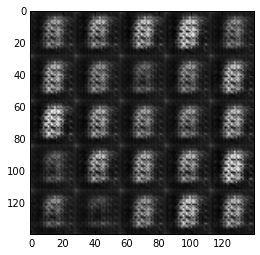

Epoch 1/2 13%... Discriminator Loss: 1.0015... Generator Loss: 0.9009
Epoch 1/2 15%... Discriminator Loss: 0.3793... Generator Loss: 5.2425
Epoch 1/2 17%... Discriminator Loss: 0.4899... Generator Loss: 2.6782
Epoch 1/2 19%... Discriminator Loss: 0.4821... Generator Loss: 2.8974
Epoch 1/2 21%... Discriminator Loss: 0.4049... Generator Loss: 3.3156


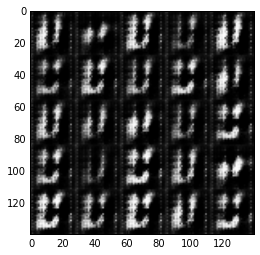

Epoch 1/2 23%... Discriminator Loss: 0.4522... Generator Loss: 2.5848
Epoch 1/2 26%... Discriminator Loss: 0.5788... Generator Loss: 1.7027
Epoch 1/2 28%... Discriminator Loss: 0.4118... Generator Loss: 4.6164
Epoch 1/2 30%... Discriminator Loss: 0.4120... Generator Loss: 3.3176
Epoch 1/2 32%... Discriminator Loss: 0.7034... Generator Loss: 4.4116


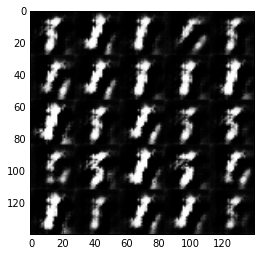

Epoch 1/2 34%... Discriminator Loss: 0.4993... Generator Loss: 3.9727
Epoch 1/2 36%... Discriminator Loss: 0.4426... Generator Loss: 2.6111
Epoch 1/2 38%... Discriminator Loss: 0.4217... Generator Loss: 2.8620
Epoch 1/2 41%... Discriminator Loss: 0.7577... Generator Loss: 1.2923
Epoch 1/2 43%... Discriminator Loss: 0.4952... Generator Loss: 2.1883


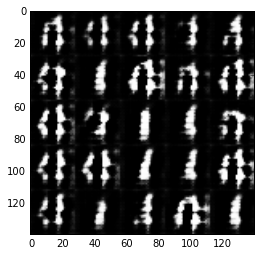

Epoch 1/2 45%... Discriminator Loss: 0.4395... Generator Loss: 2.7853
Epoch 1/2 47%... Discriminator Loss: 0.4783... Generator Loss: 2.4688
Epoch 1/2 49%... Discriminator Loss: 0.8873... Generator Loss: 1.7563
Epoch 1/2 51%... Discriminator Loss: 1.0612... Generator Loss: 0.9426
Epoch 1/2 53%... Discriminator Loss: 0.4768... Generator Loss: 3.4222


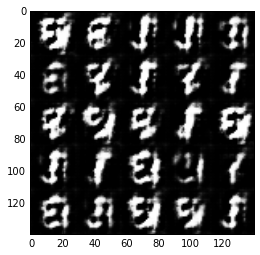

Epoch 1/2 55%... Discriminator Loss: 0.5319... Generator Loss: 4.2524
Epoch 1/2 58%... Discriminator Loss: 0.4254... Generator Loss: 3.2696
Epoch 1/2 60%... Discriminator Loss: 0.4208... Generator Loss: 2.9367
Epoch 1/2 62%... Discriminator Loss: 0.4240... Generator Loss: 3.4131
Epoch 1/2 64%... Discriminator Loss: 0.4369... Generator Loss: 2.6291


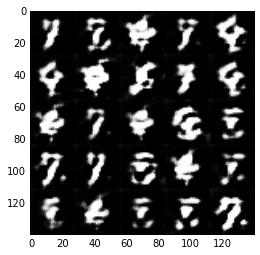

Epoch 1/2 66%... Discriminator Loss: 0.4985... Generator Loss: 2.8483
Epoch 1/2 68%... Discriminator Loss: 0.5363... Generator Loss: 2.8719
Epoch 1/2 70%... Discriminator Loss: 0.4618... Generator Loss: 2.6006
Epoch 1/2 73%... Discriminator Loss: 0.7486... Generator Loss: 1.4051
Epoch 1/2 75%... Discriminator Loss: 0.5853... Generator Loss: 2.0432


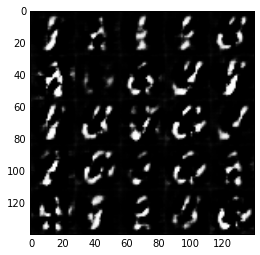

Epoch 1/2 77%... Discriminator Loss: 0.4508... Generator Loss: 3.2429
Epoch 1/2 79%... Discriminator Loss: 0.4292... Generator Loss: 3.6323
Epoch 1/2 81%... Discriminator Loss: 0.4451... Generator Loss: 2.8551
Epoch 1/2 83%... Discriminator Loss: 0.5460... Generator Loss: 1.9286
Epoch 1/2 85%... Discriminator Loss: 0.7844... Generator Loss: 1.1967


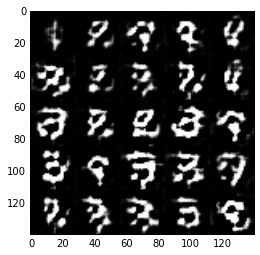

Epoch 1/2 87%... Discriminator Loss: 0.4799... Generator Loss: 3.4902
Epoch 1/2 90%... Discriminator Loss: 0.4670... Generator Loss: 5.6192
Epoch 1/2 92%... Discriminator Loss: 0.4796... Generator Loss: 4.4271
Epoch 1/2 94%... Discriminator Loss: 0.5672... Generator Loss: 1.8674
Epoch 1/2 96%... Discriminator Loss: 0.4606... Generator Loss: 2.8089


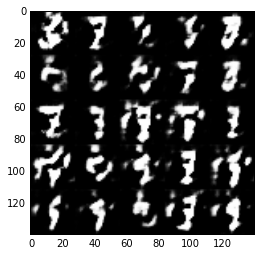

Epoch 1/2 98%... Discriminator Loss: 0.4426... Generator Loss: 3.0613
Epoch 2/2 2%... Discriminator Loss: 0.5024... Generator Loss: 3.4043
Epoch 2/2 4%... Discriminator Loss: 0.5682... Generator Loss: 2.4538
Epoch 2/2 6%... Discriminator Loss: 0.8157... Generator Loss: 1.3102
Epoch 2/2 9%... Discriminator Loss: 0.5482... Generator Loss: 2.5498
Epoch 2/2 11%... Discriminator Loss: 0.4194... Generator Loss: 3.3375


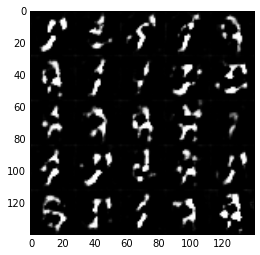

Epoch 2/2 13%... Discriminator Loss: 0.4704... Generator Loss: 3.9369
Epoch 2/2 15%... Discriminator Loss: 0.5451... Generator Loss: 2.5138
Epoch 2/2 17%... Discriminator Loss: 0.6038... Generator Loss: 4.3386
Epoch 2/2 19%... Discriminator Loss: 0.5291... Generator Loss: 3.5292
Epoch 2/2 21%... Discriminator Loss: 1.1642... Generator Loss: 0.8279


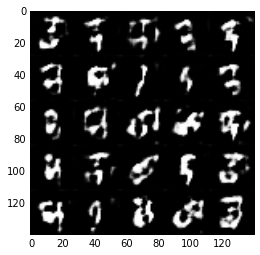

Epoch 2/2 23%... Discriminator Loss: 0.6486... Generator Loss: 1.6434
Epoch 2/2 26%... Discriminator Loss: 1.0311... Generator Loss: 0.8452
Epoch 2/2 28%... Discriminator Loss: 0.5445... Generator Loss: 2.2151
Epoch 2/2 30%... Discriminator Loss: 0.9967... Generator Loss: 0.9859
Epoch 2/2 32%... Discriminator Loss: 0.5574... Generator Loss: 2.0514


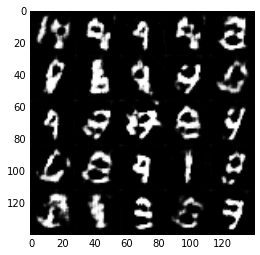

Epoch 2/2 34%... Discriminator Loss: 0.6834... Generator Loss: 2.2376
Epoch 2/2 36%... Discriminator Loss: 0.5296... Generator Loss: 3.1791
Epoch 2/2 38%... Discriminator Loss: 0.7398... Generator Loss: 2.4702
Epoch 2/2 41%... Discriminator Loss: 0.5793... Generator Loss: 2.1727
Epoch 2/2 43%... Discriminator Loss: 0.7565... Generator Loss: 1.3186


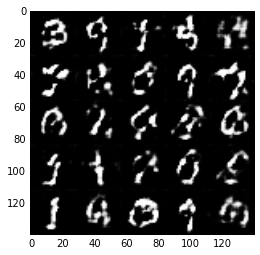

Epoch 2/2 45%... Discriminator Loss: 0.5463... Generator Loss: 2.2267
Epoch 2/2 47%... Discriminator Loss: 0.6623... Generator Loss: 1.5707
Epoch 2/2 49%... Discriminator Loss: 0.5235... Generator Loss: 2.6419
Epoch 2/2 51%... Discriminator Loss: 0.5498... Generator Loss: 2.1473
Epoch 2/2 53%... Discriminator Loss: 0.9027... Generator Loss: 3.2911


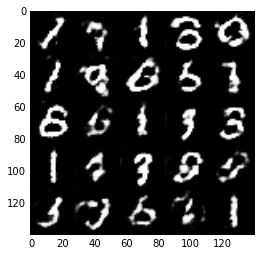

Epoch 2/2 55%... Discriminator Loss: 0.7296... Generator Loss: 1.9772
Epoch 2/2 58%... Discriminator Loss: 0.5671... Generator Loss: 1.9607
Epoch 2/2 60%... Discriminator Loss: 0.5492... Generator Loss: 2.0788
Epoch 2/2 62%... Discriminator Loss: 0.6899... Generator Loss: 1.9114
Epoch 2/2 64%... Discriminator Loss: 0.6343... Generator Loss: 1.7913


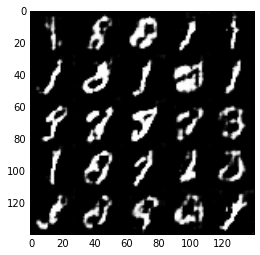

Epoch 2/2 66%... Discriminator Loss: 0.5350... Generator Loss: 2.7847
Epoch 2/2 68%... Discriminator Loss: 0.5740... Generator Loss: 2.0338
Epoch 2/2 70%... Discriminator Loss: 0.7275... Generator Loss: 1.5668
Epoch 2/2 73%... Discriminator Loss: 0.8058... Generator Loss: 1.3668
Epoch 2/2 75%... Discriminator Loss: 0.8882... Generator Loss: 1.2401


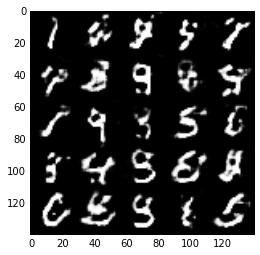

Epoch 2/2 77%... Discriminator Loss: 0.6657... Generator Loss: 2.4133
Epoch 2/2 79%... Discriminator Loss: 0.6122... Generator Loss: 2.2594
Epoch 2/2 81%... Discriminator Loss: 0.6113... Generator Loss: 1.8340
Epoch 2/2 83%... Discriminator Loss: 0.7001... Generator Loss: 1.5215
Epoch 2/2 85%... Discriminator Loss: 0.6429... Generator Loss: 1.8956


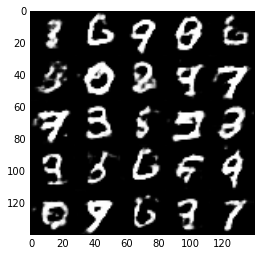

Epoch 2/2 87%... Discriminator Loss: 0.6800... Generator Loss: 1.5902
Epoch 2/2 90%... Discriminator Loss: 0.6414... Generator Loss: 1.8030
Epoch 2/2 92%... Discriminator Loss: 0.9939... Generator Loss: 1.4999
Epoch 2/2 94%... Discriminator Loss: 0.7024... Generator Loss: 1.4748
Epoch 2/2 96%... Discriminator Loss: 0.8834... Generator Loss: 1.1289


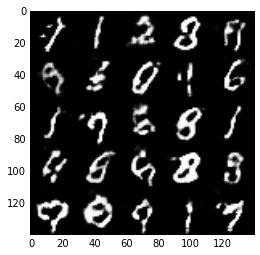

Epoch 2/2 98%... Discriminator Loss: 0.9552... Generator Loss: 1.0314


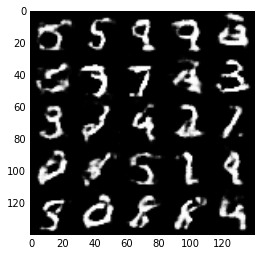

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 1%... Discriminator Loss: 0.5494... Generator Loss: 3.8332
Epoch 1/1 1%... Discriminator Loss: 0.5349... Generator Loss: 2.0623
Epoch 1/1 2%... Discriminator Loss: 1.0521... Generator Loss: 1.5320
Epoch 1/1 3%... Discriminator Loss: 0.5008... Generator Loss: 2.7324
Epoch 1/1 3%... Discriminator Loss: 1.1559... Generator Loss: 2.0168


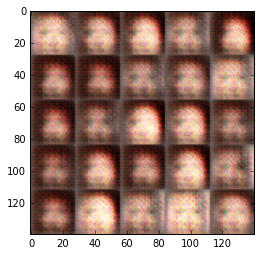

Epoch 1/1 4%... Discriminator Loss: 2.3092... Generator Loss: 0.2202
Epoch 1/1 4%... Discriminator Loss: 0.7020... Generator Loss: 2.2844
Epoch 1/1 5%... Discriminator Loss: 0.8979... Generator Loss: 2.1778
Epoch 1/1 6%... Discriminator Loss: 0.8075... Generator Loss: 1.9456
Epoch 1/1 6%... Discriminator Loss: 1.3895... Generator Loss: 3.9969


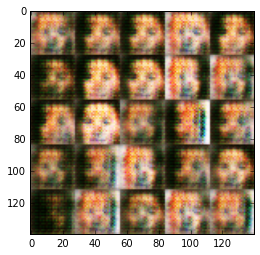

Epoch 1/1 7%... Discriminator Loss: 0.7919... Generator Loss: 1.5150
Epoch 1/1 8%... Discriminator Loss: 0.8862... Generator Loss: 1.5476
Epoch 1/1 8%... Discriminator Loss: 0.7274... Generator Loss: 2.2062
Epoch 1/1 9%... Discriminator Loss: 0.9052... Generator Loss: 1.4214
Epoch 1/1 9%... Discriminator Loss: 0.8660... Generator Loss: 1.4126


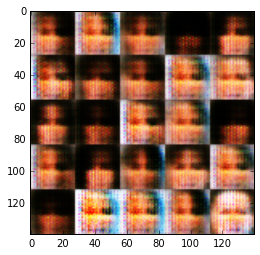

Epoch 1/1 10%... Discriminator Loss: 0.6631... Generator Loss: 1.6352
Epoch 1/1 11%... Discriminator Loss: 1.2797... Generator Loss: 3.2048
Epoch 1/1 11%... Discriminator Loss: 1.5623... Generator Loss: 0.4543
Epoch 1/1 12%... Discriminator Loss: 0.7395... Generator Loss: 1.9308
Epoch 1/1 13%... Discriminator Loss: 1.0339... Generator Loss: 1.0331


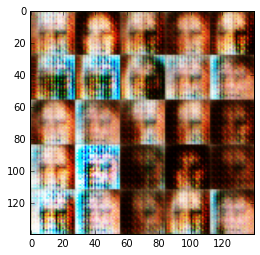

Epoch 1/1 13%... Discriminator Loss: 0.8508... Generator Loss: 2.0603
Epoch 1/1 14%... Discriminator Loss: 0.5400... Generator Loss: 2.1053
Epoch 1/1 15%... Discriminator Loss: 0.7879... Generator Loss: 1.3480
Epoch 1/1 15%... Discriminator Loss: 0.6867... Generator Loss: 1.4522
Epoch 1/1 16%... Discriminator Loss: 0.7216... Generator Loss: 1.5187


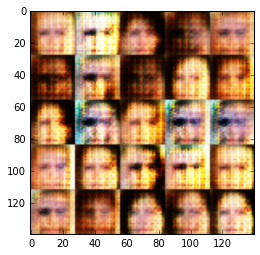

Epoch 1/1 16%... Discriminator Loss: 0.5896... Generator Loss: 2.2629
Epoch 1/1 17%... Discriminator Loss: 1.1744... Generator Loss: 0.6812
Epoch 1/1 18%... Discriminator Loss: 0.8183... Generator Loss: 3.7142
Epoch 1/1 18%... Discriminator Loss: 0.6887... Generator Loss: 1.5657
Epoch 1/1 19%... Discriminator Loss: 0.9736... Generator Loss: 0.9564


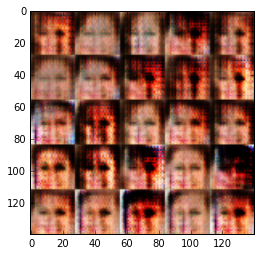

Epoch 1/1 20%... Discriminator Loss: 0.7332... Generator Loss: 3.2610
Epoch 1/1 20%... Discriminator Loss: 0.8977... Generator Loss: 1.0236
Epoch 1/1 21%... Discriminator Loss: 0.7827... Generator Loss: 1.3269
Epoch 1/1 21%... Discriminator Loss: 0.9913... Generator Loss: 0.8819
Epoch 1/1 22%... Discriminator Loss: 0.6750... Generator Loss: 1.4922


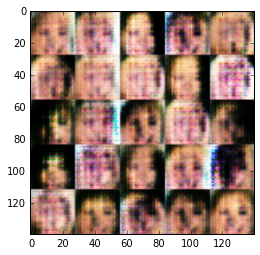

Epoch 1/1 23%... Discriminator Loss: 0.9155... Generator Loss: 1.2064
Epoch 1/1 23%... Discriminator Loss: 0.7290... Generator Loss: 3.2729
Epoch 1/1 24%... Discriminator Loss: 0.5085... Generator Loss: 2.0917
Epoch 1/1 25%... Discriminator Loss: 1.5260... Generator Loss: 4.3794
Epoch 1/1 25%... Discriminator Loss: 0.5883... Generator Loss: 2.1002


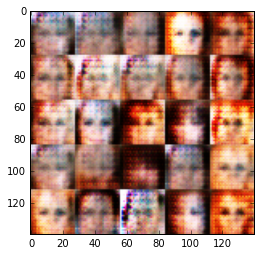

Epoch 1/1 26%... Discriminator Loss: 0.4973... Generator Loss: 2.4765
Epoch 1/1 27%... Discriminator Loss: 0.6964... Generator Loss: 1.9069
Epoch 1/1 27%... Discriminator Loss: 0.6136... Generator Loss: 1.7971
Epoch 1/1 28%... Discriminator Loss: 0.6466... Generator Loss: 1.7798
Epoch 1/1 28%... Discriminator Loss: 1.0416... Generator Loss: 0.8043


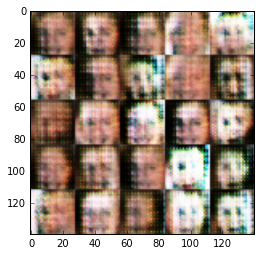

Epoch 1/1 29%... Discriminator Loss: 0.8966... Generator Loss: 1.0207
Epoch 1/1 30%... Discriminator Loss: 0.8101... Generator Loss: 2.6846
Epoch 1/1 30%... Discriminator Loss: 0.7522... Generator Loss: 2.0284
Epoch 1/1 31%... Discriminator Loss: 0.7483... Generator Loss: 1.6064
Epoch 1/1 32%... Discriminator Loss: 0.8383... Generator Loss: 3.1896


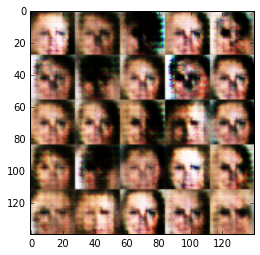

Epoch 1/1 32%... Discriminator Loss: 0.7094... Generator Loss: 1.4909
Epoch 1/1 33%... Discriminator Loss: 0.5093... Generator Loss: 2.6082
Epoch 1/1 33%... Discriminator Loss: 0.5230... Generator Loss: 2.9057
Epoch 1/1 34%... Discriminator Loss: 1.3843... Generator Loss: 0.5181
Epoch 1/1 35%... Discriminator Loss: 0.7510... Generator Loss: 1.3024


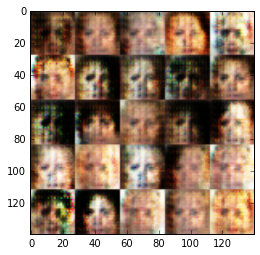

Epoch 1/1 35%... Discriminator Loss: 0.6406... Generator Loss: 1.5199
Epoch 1/1 36%... Discriminator Loss: 0.5445... Generator Loss: 2.0363
Epoch 1/1 37%... Discriminator Loss: 1.0419... Generator Loss: 4.3192
Epoch 1/1 37%... Discriminator Loss: 0.7400... Generator Loss: 2.1092
Epoch 1/1 38%... Discriminator Loss: 0.8299... Generator Loss: 1.1865


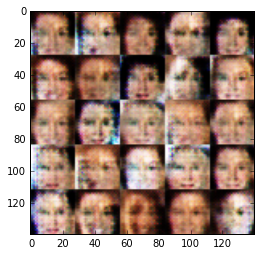

Epoch 1/1 39%... Discriminator Loss: 0.5008... Generator Loss: 2.4299
Epoch 1/1 39%... Discriminator Loss: 1.3795... Generator Loss: 4.1980
Epoch 1/1 40%... Discriminator Loss: 0.7067... Generator Loss: 2.8585
Epoch 1/1 40%... Discriminator Loss: 0.6506... Generator Loss: 2.1700
Epoch 1/1 41%... Discriminator Loss: 0.8073... Generator Loss: 1.2505


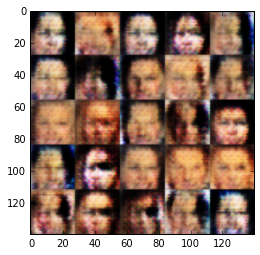

Epoch 1/1 42%... Discriminator Loss: 0.5735... Generator Loss: 2.9091
Epoch 1/1 42%... Discriminator Loss: 0.9751... Generator Loss: 0.9278
Epoch 1/1 43%... Discriminator Loss: 0.8824... Generator Loss: 1.0371
Epoch 1/1 44%... Discriminator Loss: 1.1779... Generator Loss: 3.6705
Epoch 1/1 44%... Discriminator Loss: 0.8435... Generator Loss: 1.1194


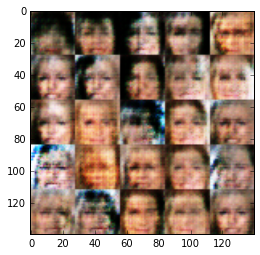

Epoch 1/1 45%... Discriminator Loss: 0.8271... Generator Loss: 1.1898
Epoch 1/1 45%... Discriminator Loss: 2.2564... Generator Loss: 6.6116
Epoch 1/1 46%... Discriminator Loss: 1.5004... Generator Loss: 4.8384
Epoch 1/1 47%... Discriminator Loss: 0.4616... Generator Loss: 3.8819
Epoch 1/1 47%... Discriminator Loss: 1.0802... Generator Loss: 0.7864


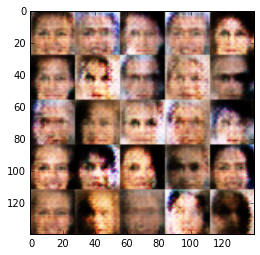

Epoch 1/1 48%... Discriminator Loss: 1.4256... Generator Loss: 4.4068
Epoch 1/1 49%... Discriminator Loss: 0.7196... Generator Loss: 1.4107
Epoch 1/1 49%... Discriminator Loss: 0.5703... Generator Loss: 2.0590
Epoch 1/1 50%... Discriminator Loss: 0.5333... Generator Loss: 2.7405
Epoch 1/1 51%... Discriminator Loss: 0.7057... Generator Loss: 2.1254


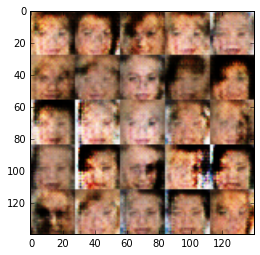

Epoch 1/1 51%... Discriminator Loss: 1.2020... Generator Loss: 0.7702
Epoch 1/1 52%... Discriminator Loss: 0.7182... Generator Loss: 1.3990
Epoch 1/1 52%... Discriminator Loss: 0.9577... Generator Loss: 0.9711
Epoch 1/1 53%... Discriminator Loss: 0.6080... Generator Loss: 1.9079
Epoch 1/1 54%... Discriminator Loss: 0.8883... Generator Loss: 1.0354


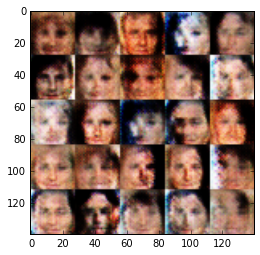

Epoch 1/1 54%... Discriminator Loss: 0.6771... Generator Loss: 2.9050
Epoch 1/1 55%... Discriminator Loss: 1.1917... Generator Loss: 0.8046
Epoch 1/1 56%... Discriminator Loss: 0.6148... Generator Loss: 2.5388
Epoch 1/1 56%... Discriminator Loss: 0.6395... Generator Loss: 1.7538
Epoch 1/1 57%... Discriminator Loss: 0.5217... Generator Loss: 2.3971


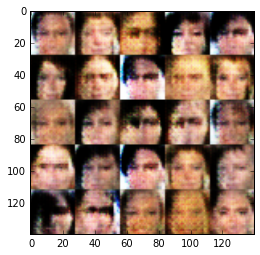

Epoch 1/1 57%... Discriminator Loss: 0.6779... Generator Loss: 1.8837
Epoch 1/1 58%... Discriminator Loss: 0.7319... Generator Loss: 1.4326
Epoch 1/1 59%... Discriminator Loss: 0.7529... Generator Loss: 1.2186
Epoch 1/1 59%... Discriminator Loss: 0.6226... Generator Loss: 1.7176
Epoch 1/1 60%... Discriminator Loss: 0.9328... Generator Loss: 0.9435


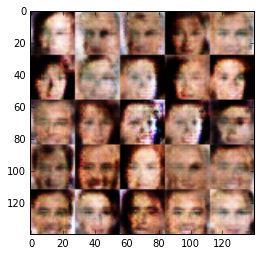

Epoch 1/1 61%... Discriminator Loss: 0.5842... Generator Loss: 2.7620
Epoch 1/1 61%... Discriminator Loss: 0.6720... Generator Loss: 1.4572
Epoch 1/1 62%... Discriminator Loss: 0.9372... Generator Loss: 1.2154
Epoch 1/1 63%... Discriminator Loss: 0.6742... Generator Loss: 1.9402
Epoch 1/1 63%... Discriminator Loss: 0.8312... Generator Loss: 1.1628


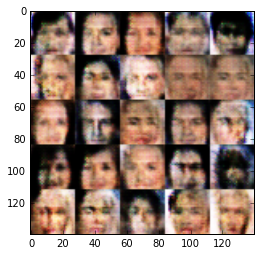

Epoch 1/1 64%... Discriminator Loss: 0.8452... Generator Loss: 1.1862
Epoch 1/1 64%... Discriminator Loss: 0.6329... Generator Loss: 3.1821
Epoch 1/1 65%... Discriminator Loss: 1.3732... Generator Loss: 0.5703
Epoch 1/1 66%... Discriminator Loss: 0.9936... Generator Loss: 3.5274
Epoch 1/1 66%... Discriminator Loss: 0.6443... Generator Loss: 3.0092


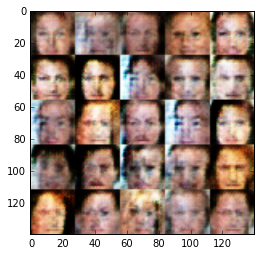

Epoch 1/1 67%... Discriminator Loss: 0.7975... Generator Loss: 1.1328
Epoch 1/1 68%... Discriminator Loss: 1.0825... Generator Loss: 0.7473
Epoch 1/1 68%... Discriminator Loss: 1.2024... Generator Loss: 4.9735
Epoch 1/1 69%... Discriminator Loss: 0.6415... Generator Loss: 1.9121
Epoch 1/1 69%... Discriminator Loss: 0.8640... Generator Loss: 1.0777


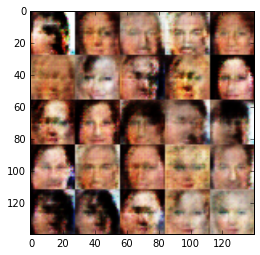

Epoch 1/1 70%... Discriminator Loss: 0.7091... Generator Loss: 1.3889
Epoch 1/1 71%... Discriminator Loss: 0.7095... Generator Loss: 1.4690
Epoch 1/1 71%... Discriminator Loss: 1.1919... Generator Loss: 0.6252
Epoch 1/1 72%... Discriminator Loss: 0.7460... Generator Loss: 3.2020
Epoch 1/1 73%... Discriminator Loss: 0.6116... Generator Loss: 2.7941


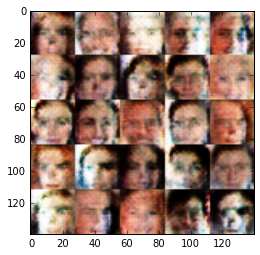

Epoch 1/1 73%... Discriminator Loss: 0.5539... Generator Loss: 2.0457
Epoch 1/1 74%... Discriminator Loss: 0.6969... Generator Loss: 1.7183
Epoch 1/1 75%... Discriminator Loss: 0.6304... Generator Loss: 1.6608
Epoch 1/1 75%... Discriminator Loss: 0.5540... Generator Loss: 2.4277
Epoch 1/1 76%... Discriminator Loss: 0.6828... Generator Loss: 1.5029


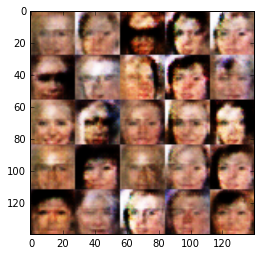

Epoch 1/1 76%... Discriminator Loss: 0.6077... Generator Loss: 2.0301
Epoch 1/1 77%... Discriminator Loss: 0.6643... Generator Loss: 1.6671
Epoch 1/1 78%... Discriminator Loss: 0.8105... Generator Loss: 1.2498
Epoch 1/1 78%... Discriminator Loss: 0.7034... Generator Loss: 1.4138
Epoch 1/1 79%... Discriminator Loss: 0.7077... Generator Loss: 1.5046


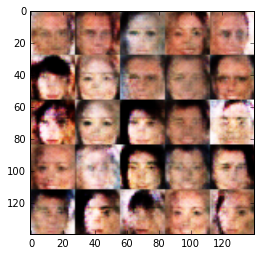

Epoch 1/1 80%... Discriminator Loss: 0.6267... Generator Loss: 1.8406
Epoch 1/1 80%... Discriminator Loss: 0.7045... Generator Loss: 1.5421
Epoch 1/1 81%... Discriminator Loss: 0.7049... Generator Loss: 3.1329
Epoch 1/1 82%... Discriminator Loss: 0.4863... Generator Loss: 2.8161
Epoch 1/1 82%... Discriminator Loss: 0.5574... Generator Loss: 2.3921


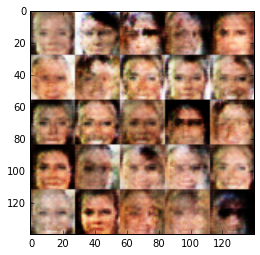

Epoch 1/1 83%... Discriminator Loss: 0.5986... Generator Loss: 2.0429
Epoch 1/1 83%... Discriminator Loss: 0.8281... Generator Loss: 2.5274
Epoch 1/1 84%... Discriminator Loss: 0.5629... Generator Loss: 2.2995
Epoch 1/1 85%... Discriminator Loss: 0.7695... Generator Loss: 1.2788
Epoch 1/1 85%... Discriminator Loss: 0.5727... Generator Loss: 2.5243


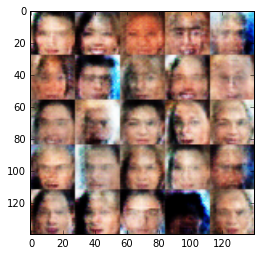

Epoch 1/1 86%... Discriminator Loss: 0.6602... Generator Loss: 1.6918
Epoch 1/1 87%... Discriminator Loss: 0.6990... Generator Loss: 2.9273
Epoch 1/1 87%... Discriminator Loss: 0.9245... Generator Loss: 4.7065
Epoch 1/1 88%... Discriminator Loss: 0.6862... Generator Loss: 2.1736
Epoch 1/1 88%... Discriminator Loss: 0.5430... Generator Loss: 2.2056


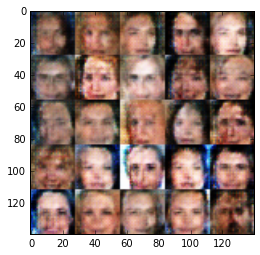

Epoch 1/1 89%... Discriminator Loss: 0.7231... Generator Loss: 2.3772
Epoch 1/1 90%... Discriminator Loss: 0.6057... Generator Loss: 1.8074
Epoch 1/1 90%... Discriminator Loss: 0.8944... Generator Loss: 4.6772
Epoch 1/1 91%... Discriminator Loss: 0.6223... Generator Loss: 1.9238
Epoch 1/1 92%... Discriminator Loss: 1.1016... Generator Loss: 3.9839


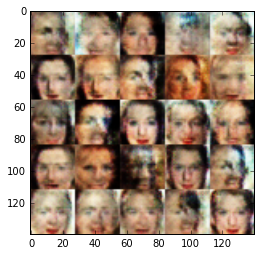

Epoch 1/1 92%... Discriminator Loss: 0.8792... Generator Loss: 4.2073
Epoch 1/1 93%... Discriminator Loss: 0.6480... Generator Loss: 1.7126
Epoch 1/1 94%... Discriminator Loss: 0.6089... Generator Loss: 2.4592
Epoch 1/1 94%... Discriminator Loss: 1.0598... Generator Loss: 0.8087
Epoch 1/1 95%... Discriminator Loss: 0.6361... Generator Loss: 1.7592


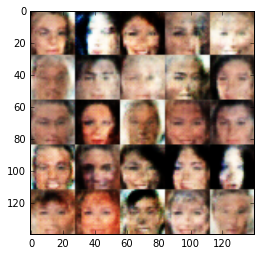

Epoch 1/1 95%... Discriminator Loss: 0.7183... Generator Loss: 1.4456
Epoch 1/1 96%... Discriminator Loss: 0.6241... Generator Loss: 2.4092
Epoch 1/1 97%... Discriminator Loss: 0.7737... Generator Loss: 3.6872
Epoch 1/1 97%... Discriminator Loss: 0.6795... Generator Loss: 1.5118
Epoch 1/1 98%... Discriminator Loss: 0.7833... Generator Loss: 1.2211


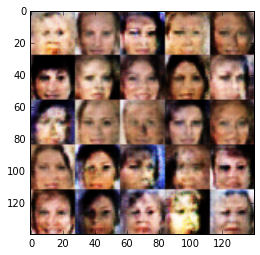

Epoch 1/1 99%... Discriminator Loss: 0.5961... Generator Loss: 2.6649
Epoch 1/1 99%... Discriminator Loss: 0.5881... Generator Loss: 2.1352
Epoch 1/1 100%... Discriminator Loss: 0.6273... Generator Loss: 1.9450


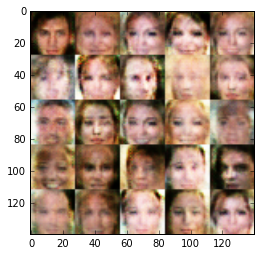

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.